# Practical Machine Learning for Physicists
## Prediction of movement for a Harmonic Oscillator (LSTMs)
In this notebook you will be trying to predict a system using incomplete information. We will set up the equations of motions for a simple double pendulum (or should that be a double simple pendulum. Then we will see if a machine learning technique can predict the future position of the lower mass, using only the lower mass positions.

### Kinematics of the double pendulum
Let's specify our problem in terms of the following, with the origin at the pivot point of the top pendulum. This is just background for the machine learning tasks at the bottom of the notebook.

#### Positions
$$x_1 = L_1 \sin \theta_1$$
$$y_1 = -L_1 \cos \theta_1$$
$$x_2 = x_1 + L_2 \sin \theta_2$$
$$y_2 = y_1 - L_2 \cos \theta_2$$

#### Velocities
$$\dot{x}_1 = \dot{\theta_1} L_1 \cos \theta_1$$
$$\dot{y_1} =  \dot{\theta_1} L_1 \sin \theta_1$$
$$\dot{x_2} = \dot{x_1} + \dot{\theta_2} L_2 \cos \theta_2$$
$$\dot{y_2} = \dot{y_1} + \dot{\theta_2} L_2 \sin \theta_2$$


#### Accelerations

$$\ddot{x}_1 = -\dot{\theta_1}^2 L_1 \sin \theta_1 + \ddot{\theta_1} L_1 \cos \theta_1$$
$$\ddot{y_1} =  \dot{\theta_1}^2 L_1 \cos \theta_1 + \ddot{\theta_1} L_1 \sin \theta_1$$
$$\ddot{x_2} = \ddot{x_1} - \dot{\theta_2}^2 L_2 \sin \theta_2 + \ddot{\theta_2} L_2 \cos \theta_2$$
$$\ddot{y_2} = \ddot{y_1} + \dot{\theta_2}^2 L_2 \cos \theta_2 + \ddot{\theta_2} L_2 \sin \theta_2$$

#### Energies
Let $v_1^2 = \dot{x_1}^2 +\dot{y_1}^2$ and $v_2^2 = \dot{x_2}^2 +\dot{y_2}^2$ then the kinetic energies $T_1$ and $T_2$ are
$$ T_1 = \frac{1}{2}m_1 v_1^2 = \frac{1}{2}m_1 L_1^2 \dot{\theta_1}^2 $$
$$ T_2 = \frac{1}{2}m_2 v_2^2 = \frac{1}{2}m_2 \left( L_1^2 \dot{\theta_1}^2 + L_2^2 \dot{\theta_2}^2 + 2L_1 L_2 \cos(\theta_1-\theta_2) \dot{\theta_1} \dot{\theta_2} \right) $$

The potential energies are
$$V_1 = m_1 g y_1 = - m_1 g L_1 \cos \theta_1$$
$$V_2 = m_2 g y_2 = -m_2 g ( L_1 \cos \theta_1 + L_2 \cos \theta_2)$$

#### Langrangian
Now we form the Lagrangian $L=T-V=T_1+T_2 -V_1 -V_2$ and use the Euler-Lagrange equations:
$$\frac{\partial L}{\partial \theta_1} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}}$$
$$\frac{\partial L}{\partial \theta_2} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}}$$

Applying these gives
$$-(m_1+m_2) g L_1 \sin \theta_1 = (m_1+m_2) L_1^2 \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_2}^2 +  m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_2} $$
and
$$ -m_2 g L_2 \sin \theta_2 = m_2 L_2 \ddot{\theta_2} + m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_1}^2 $$


#### Equations of motions
$$ \omega_1 = \dot{\theta_1}$$  

$$ \omega_2 = \dot{\theta_2}$$
$$ \ddot\theta_1 = \frac{1}{L_1\xi}\left[L_1m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_1^2 + L_2m_2\sin(\theta_1-\theta_2)\omega_2^2 - m_2g\cos(\theta_1-\theta_2)\sin(\theta_2) + (m_1+m_2)g\sin(\theta_1) \right] $$
$$ \ddot\theta_2 = \frac{1}{L_2\xi}\left[L_2m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_2^2 + L_1(m_1+m_2)\sin(\theta_1-\theta_2)\omega_1^2+(m_1+m_2)g\sin(\theta_1)\cos(\theta_1-\theta_2) - (m_1+m_2)g\sin(\theta_2) \right] $$
where
$$\xi \equiv \cos^2(\theta_1-\theta_2)m_2-m_1-m_2$$


## Tasks: Predicting Chaos (Independent)
1. Program the double harmonic oscillator
2. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$.
3. How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp
4. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)
5. Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.
6. Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import matplotlib.style
import matplotlib as mpl

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] # Inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

In [ ]:
def rhs(t, z, L1, L2, m1, m2, g):
    """
    Returns the right-hand side of the ordinary differential equation describing the double pendulem
    """
    theta1, w1, theta2, w2 = z    # The four components
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2*m2 - m1 - m2
    w1dot = ( L1*m2*cos12*sin12*w1**2 + L2*m2*sin12*w2**2
            - m2*g*cos12*sin2      + (m1 + m2)*g*sin1)/(L1*xi)
    w2dot = -( L2*m2*cos12*sin12*w2**2 + L1*(m1 + m2)*sin12*w1**2
            + (m1 + m2)*g*sin1*cos12  - (m1 + m2)*g*sin2 )/(L2*xi)
    return w1, w1dot, w2, w2dot   # Return the w's and the wdot's


def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    """ Transforms theta and omega to cartesian coordinates
    and velocities x1, y1, x2, y2, vx1, vy1, vx2, vy2
    """
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    vx1 = L1*np.cos(theta1)*w1
    vy1 = L1*np.sin(theta1)*w1
    vx2 = vx1 + L2*np.cos(theta2)*w2
    vy2 = vy1 + L2*np.sin(theta2)*w2
    return x1, y1, x2, y2, vx1, vy1, vx2, vy2


In [ ]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

# Starting angles
z0=[np.pi/4,0,np.pi/4,0]
#z0=[0.1,0,0.1,0]

# Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

In [ ]:
# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

(4, 501)


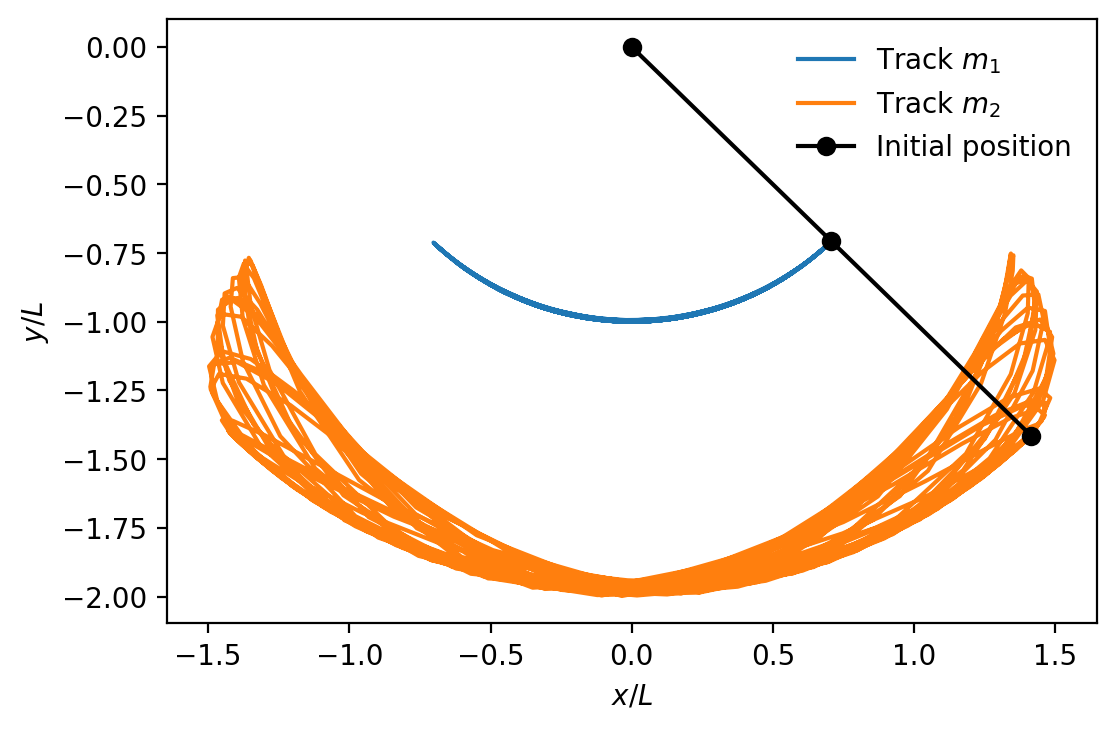

In [ ]:
fig,ax=plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

First to import the necessary modules and define `shapeArray` which will allow us to split our data into input and target windows. The `windowsize` is essentially our number of samples and the `offset` is how many steps farther we want to make a prediction at.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm

In [ ]:
def shapeArray(x,windowsize,offset):
  """
  Splits up a 1-d array x into a series of overlapping windows.
  Returns a tuple of the array of input windows and target (label) windows
  """
  first_point=len(x)-(windowsize+offset)
  xInput= np.array([x[i : i + windowsize] for i in range(first_point)]) # generate input windows
  xLabel= np.array([x[i+ windowsize+offset] for i in range(first_point)]) # generate target windows
  return (xInput,xLabel)

## Task 1
Now to make our model able to predict successfully the positions of m1 and m2 using an LSTM layer. The positions must be stacked together such that our model is able to train on it.

In [ ]:
def predict(windowsize,offset,x1,y1,x2,y2):
  '''
  Creates a model with an LSTM layer of 64 neurons trained on the first 400 input positions
  that can then predict the future positions of the masses. Returns each of the
  4 positions as arrays.
  '''


  data = np.stack([x1, y1, x2, y2]).T # create a matrix of all data for model

  # split data into training and testing sets
  train_data = data[:400]
  test_data = data

  # get input and target windows
  train_inputs, train_outputs = shapeArray(train_data, windowsize, offset)
  test_in, test_out = shapeArray(test_data, windowsize, offset)

  # define model with LSTM layer of 64 neurons
  model = model=keras.models.Sequential()
  model.add(keras.layers.LSTM(64,input_shape=(None,4),return_sequences=False))
  model.add(keras.layers.Dense(4,activation="linear"))
  model.compile(loss='mean_squared_error',optimizer='adam') # compile

  # train and predict on
  model.fit(train_inputs, train_outputs, batch_size = 100, epochs=100, verbose=0)
  preds = model.predict(test_in)

  # re-split matrix into positions of masses
  x1pred = preds[:,0 ]
  y1pred = preds[:,1 ]
  x2pred = preds[:,2 ]
  y2pred = preds[:,3 ]

  return x1pred,y1pred,x2pred,y2pred

In [ ]:
x1pred,y1pred,x2pred,y2pred = predict(10,20,x1,y1,x2,y2) # predict on initial conditions

15/15 [==============================] - 2s 8ms/step


## Task 2
Time to visualise how well our model is predicting compared to the actual solutions from `solve_ivp`.

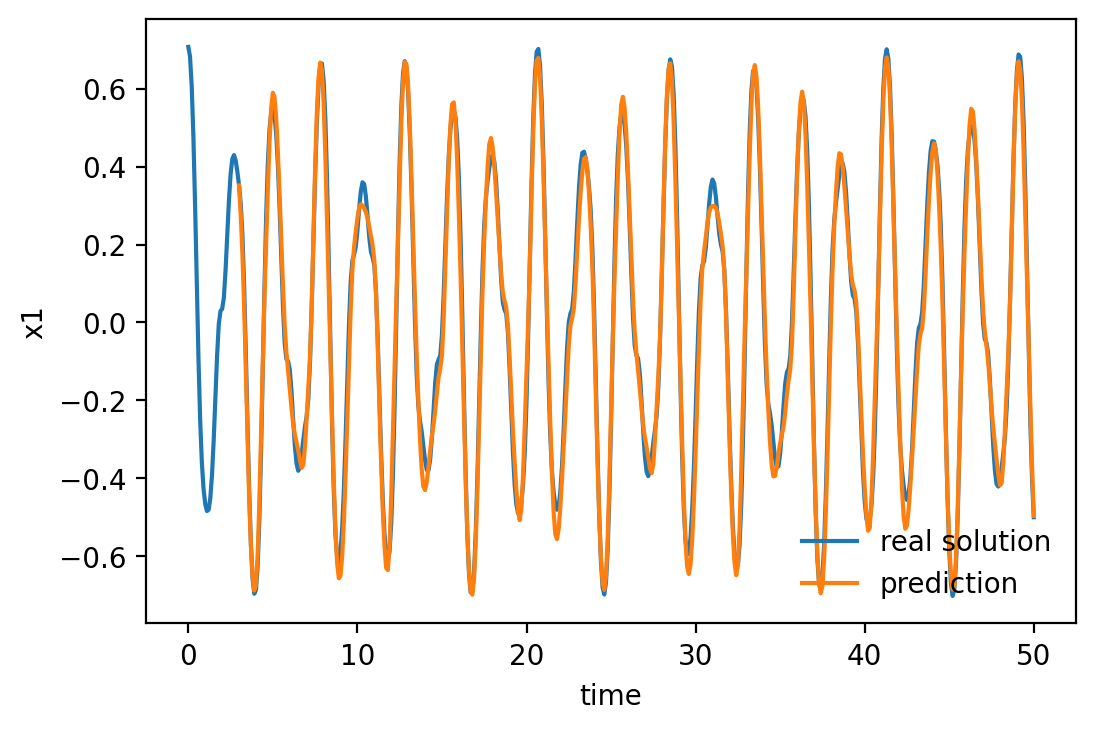

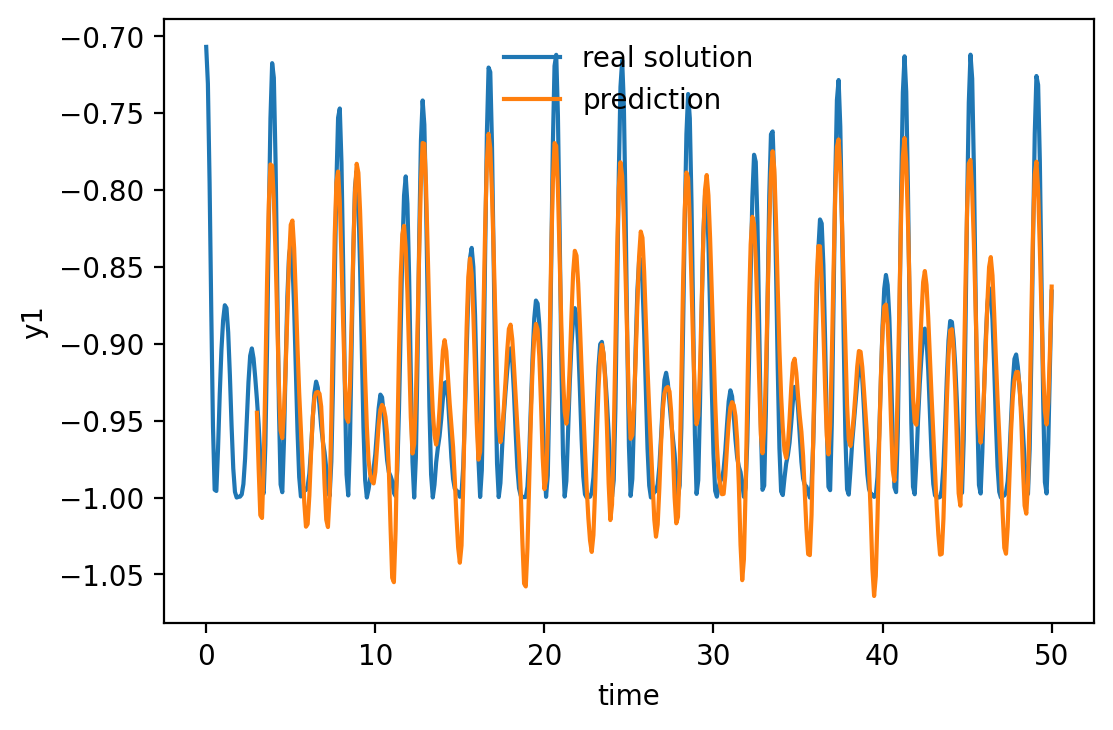

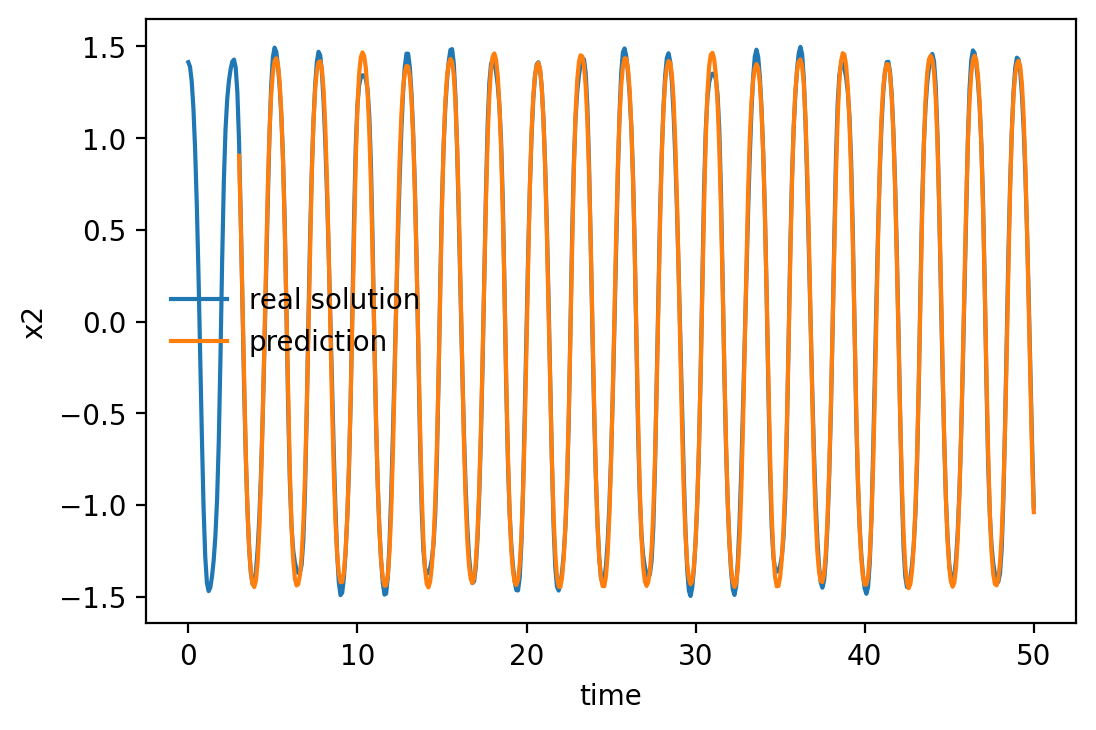

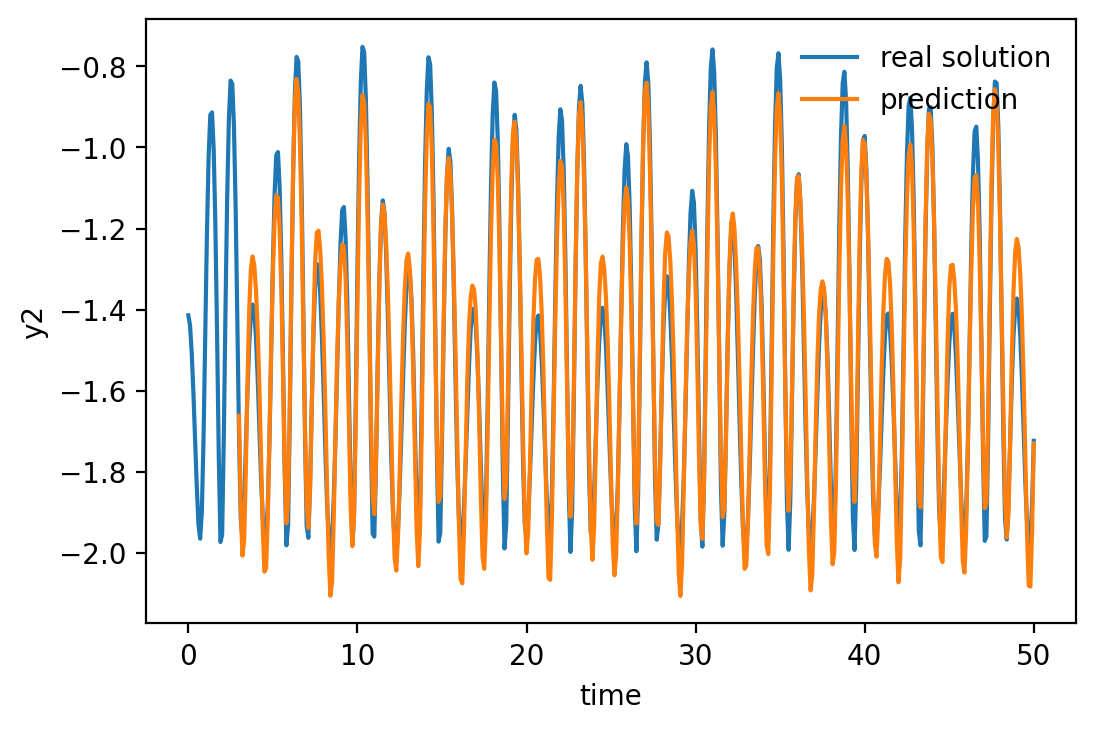

In [ ]:
def predplot(x1,x1pred,y1,y1pred,x2,x2pred,y2,y2pred,windowsize,offset,dt):
  '''
  Produces plots of real mass positions compared to predicted positions
  '''
  time = np.linspace(t[windowsize+offset],tmax,len(x1pred)) # time array for predicted data

  # x1 positions
  plt.figure()
  plt.plot(t,x1,label='real solution')
  plt.plot(time,x1pred,label='prediction')
  plt.xlabel('time')
  plt.ylabel('x1')
  plt.legend()

  # y1 positions
  plt.figure()
  plt.plot(t,y1,label='real solution')
  plt.plot(time,y1pred,label='prediction')
  plt.xlabel('time')
  plt.ylabel('y1')
  plt.legend()

  # x2 positions
  plt.figure()
  plt.plot(t,x2,label='real solution')
  plt.plot(time,x2pred,label='prediction')
  plt.xlabel('time')
  plt.ylabel('x2')
  plt.legend()

  # y2 positions
  plt.figure()
  plt.plot(t,y2,label='real solution')
  plt.plot(time,y2pred,label='prediction')
  plt.xlabel('time')
  plt.ylabel('y2')
  plt.legend()


predplot(x1,x1pred,y1,y1pred,x2,x2pred,y2,y2pred,10,20,2) # plots for initial conditions



## Task 3
Now we can evaluate the deviations between our model's predictions and the actual positions. We will do this for offsets between 20 and 100 to see if predicting further into the future will cause any further disagreement between the prediction and the real values.

13/13 [==============================] - 1s 3ms/step


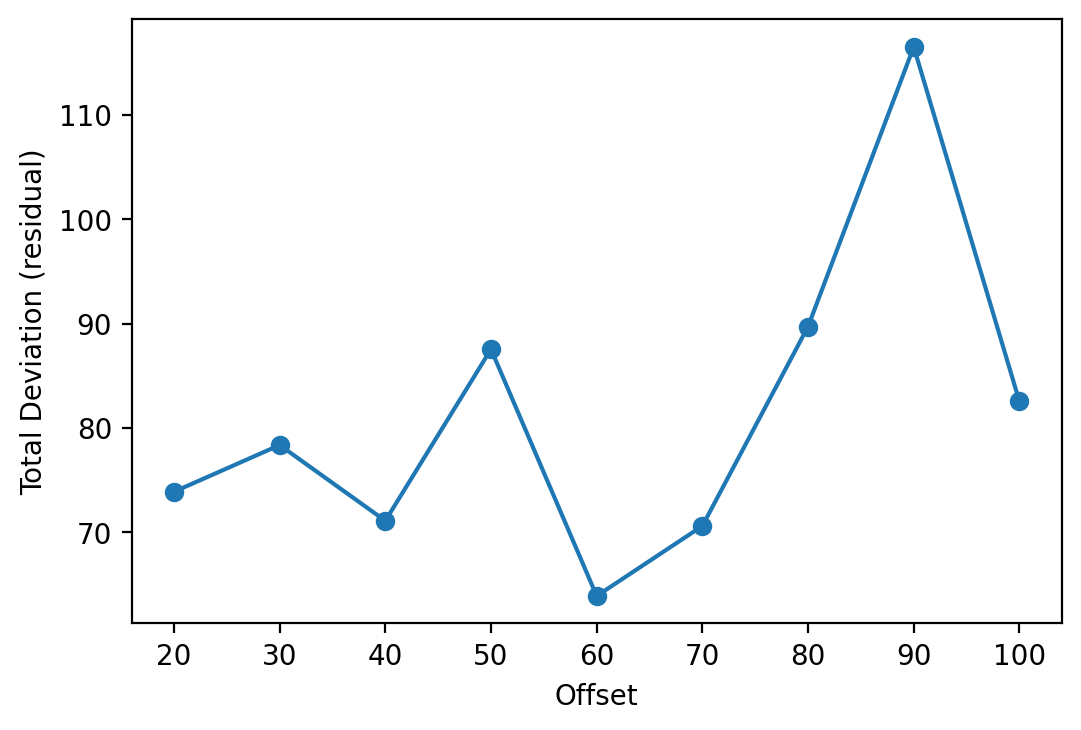

In [ ]:
def deviations(x1,y1,x2,y2,windowsize,task5=False):
  '''
  Calculates the deviations between the model predicted positions and the actual
  positions from solve_ivp at increasing offsets, producing a plot
  '''
  offsets = [20,30,40,50,60,70,80,90,100] # offsets to predict at
  totresd = [] # total residual across all positions
  for i in range(len(offsets)):
    # initialise for each offset
    x1res = 0
    y1res = 0
    x2res = 0
    y2res = 0
    # get predictions for offset
    if task5 == True:
      x1pred,y1pred,x2pred,y2pred = predict2(windowsize,offsets[i],x1,y1,x2,y2)
    else:
      x1pred,y1pred,x2pred,y2pred = predict(windowsize,offsets[i],x1,y1,x2,y2)
    for k in range(len(x1pred)):
      # get (positive) residuals at each point
      x1res += (abs(x1[k+windowsize+offsets[i]]-x1pred[k]))
      y1res += (abs(y1[k+windowsize+offsets[i]]-y1pred[k]))
      x2res += (abs(x2[k+windowsize+offsets[i]]-x2pred[k]))
      y2res += (abs(y2[k+windowsize+offsets[i]]-y2pred[k]))
    totresd.append(x1res+y1res+x2res+y2res) # add to total

  # plot total residual
  plt.figure()
  plt.plot(offsets,totresd, '-o')
  plt.xlabel("Offset")
  plt.ylabel("Total Deviation (residual)")

deviations(x1,y1,x2,y2,10) # deviations for initial conditions

Seems like the deviations are random for our initial conditions and as such, we can infer that a larger offset does not have any significant impact on our deviation, and therefore we might be able to accurately predict the future here. This is because the magnitude of the deviations does not vary wildly.

# Task 4
Now to see what the impact will be of changing our initial conditions to a more chaotic system on our predictions. Here $z_0=[\pi/2,0,\pi/2,0]$.

13/13 [==============================] - 1s 4ms/step


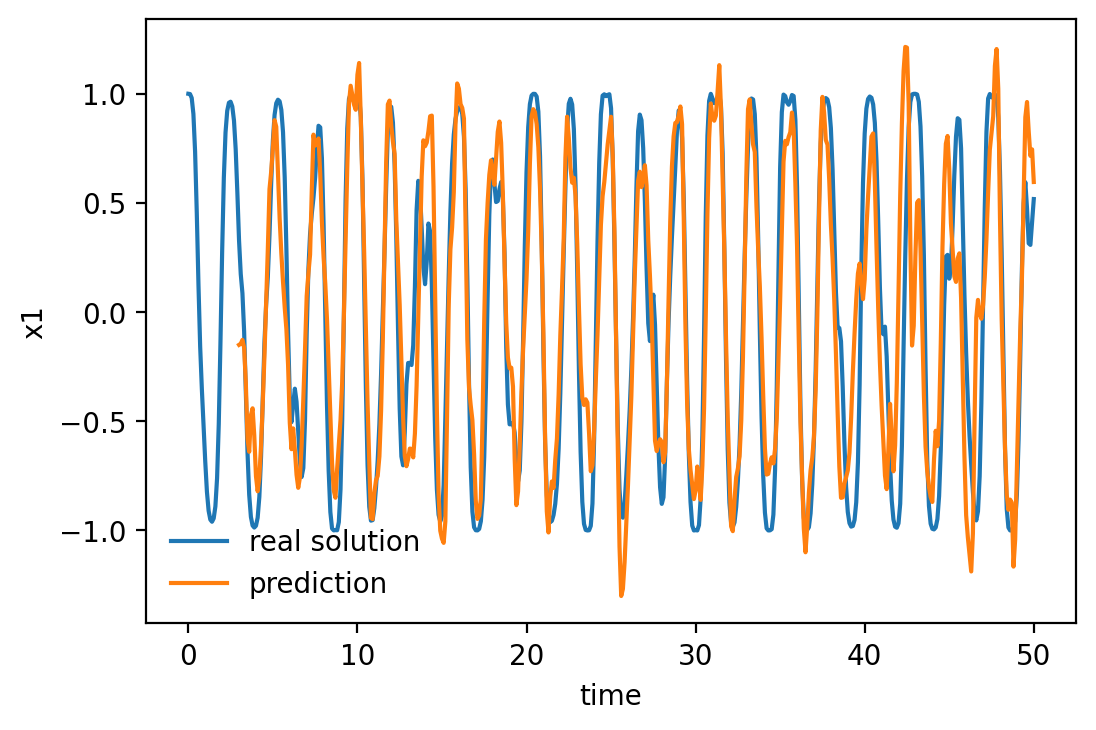

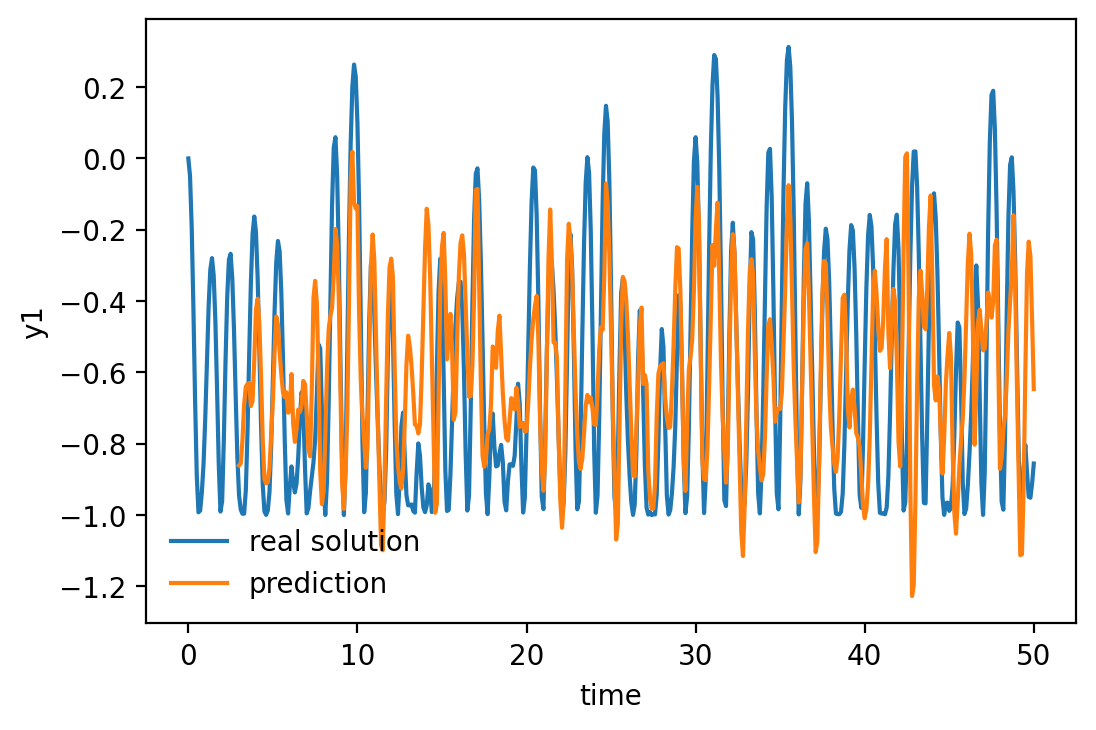

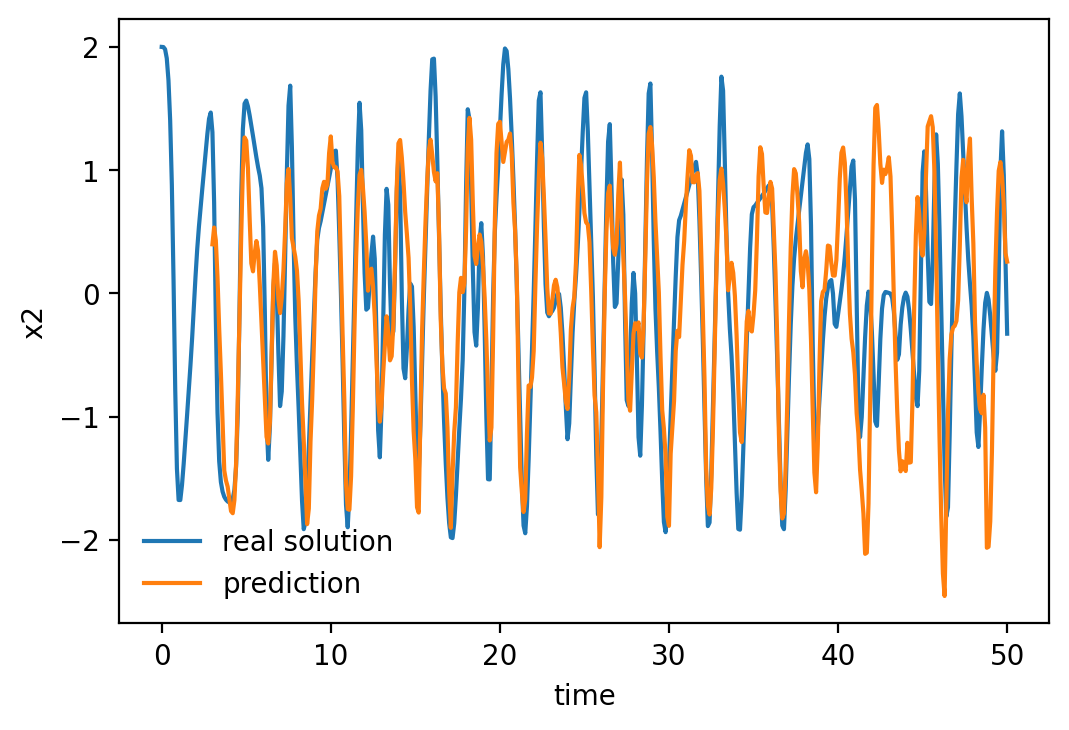

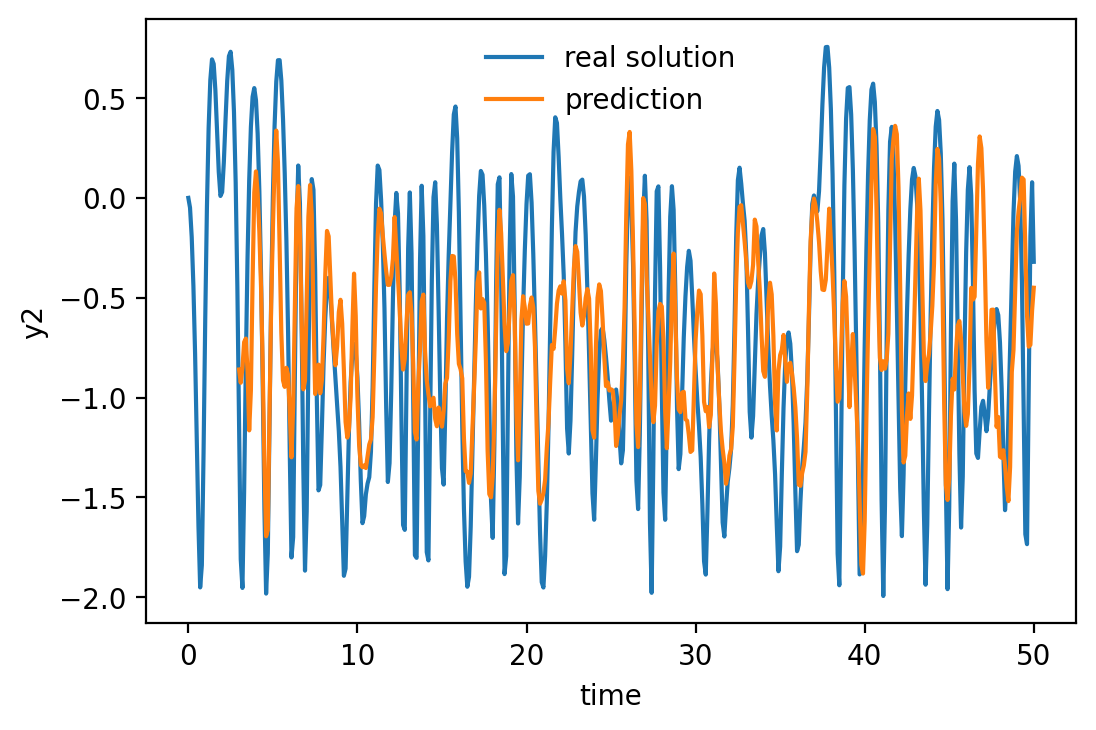

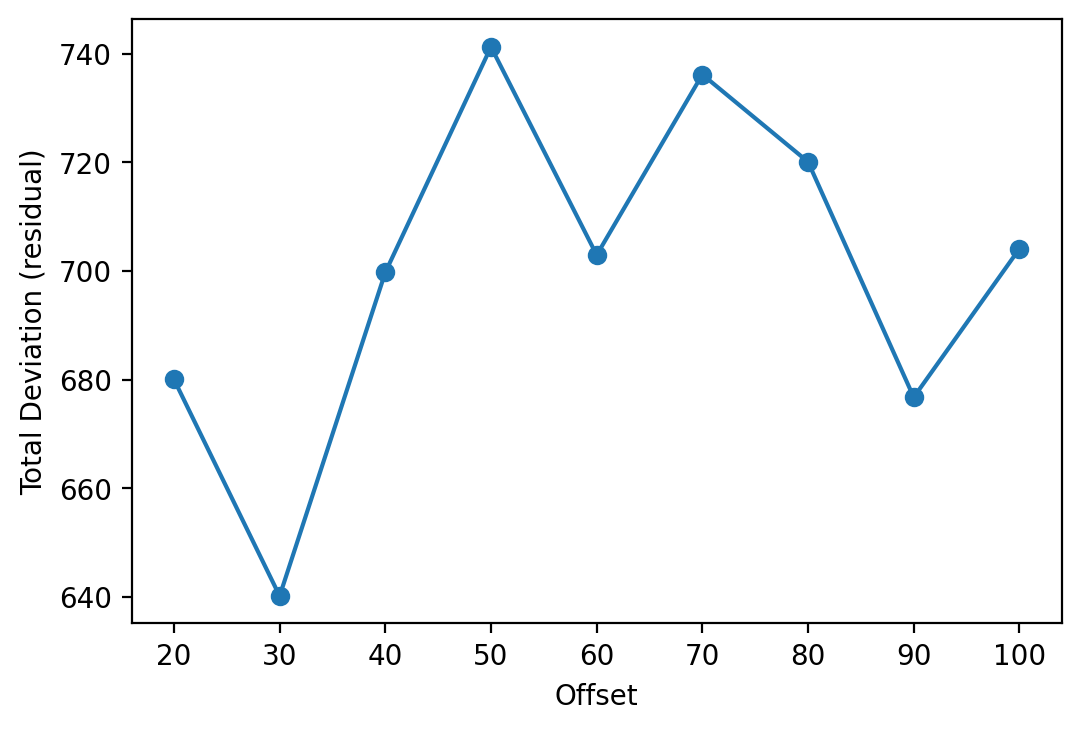

In [ ]:
def task4(z,rhs,tmax,t,L1,L2,m1,m2,g,task5=False):
  '''
  Changes the initial conditions and thus the positions of masses m1 and m2
  before using an RNN with an LSTM layer of 64 neurons to predict the future positions.
  Produces plots of prediction vs solution and total deviation
  '''
  # solve function with new conditions
  ret = solve_ivp(rhs, (0,tmax), z1, t_eval=t, args=(L1, L2, m1, m2, g))
  z=ret.y

  # extract results
  theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
  x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

  if task5 == True:
    x1pred,y1pred,x2pred,y2pred = predict2(10,20,x1,y1,x2,y2) # generate prediction
    predplot(x1,x1pred,y1,y1pred,x2,x2pred,y2,y2pred,10,20,2) # prediction vs real solution plots
    deviations(x1,y1,x2,y2,10,task5=True) # total deviation plots
  else:
    x1pred,y1pred,x2pred,y2pred = predict(10,20,x1,y1,x2,y2) # generate prediction
    predplot(x1,x1pred,y1,y1pred,x2,x2pred,y2,y2pred,10,20,2) # prediction vs real solution plots
    deviations(x1,y1,x2,y2,10) # total deviation plots

z1 = [np.pi/2,0,np.pi/2,0] # new initial conditions
task4(z1,rhs,tmax,t,L1,L2,m1,m2,g)


Seems like our predictions are not as good with a more chaotic system. The deviations are higher and it looks like higher offsets will lead to a worse prediction when compared to the real data in this case.

## Task 5
Now we can redo Tasks 1-4 but this time, only train our network on the positions of $m_2$. Then we can see what will happen to our predictions for both the masses in this scenario.

15/15 [==============================] - 0s 3ms/step


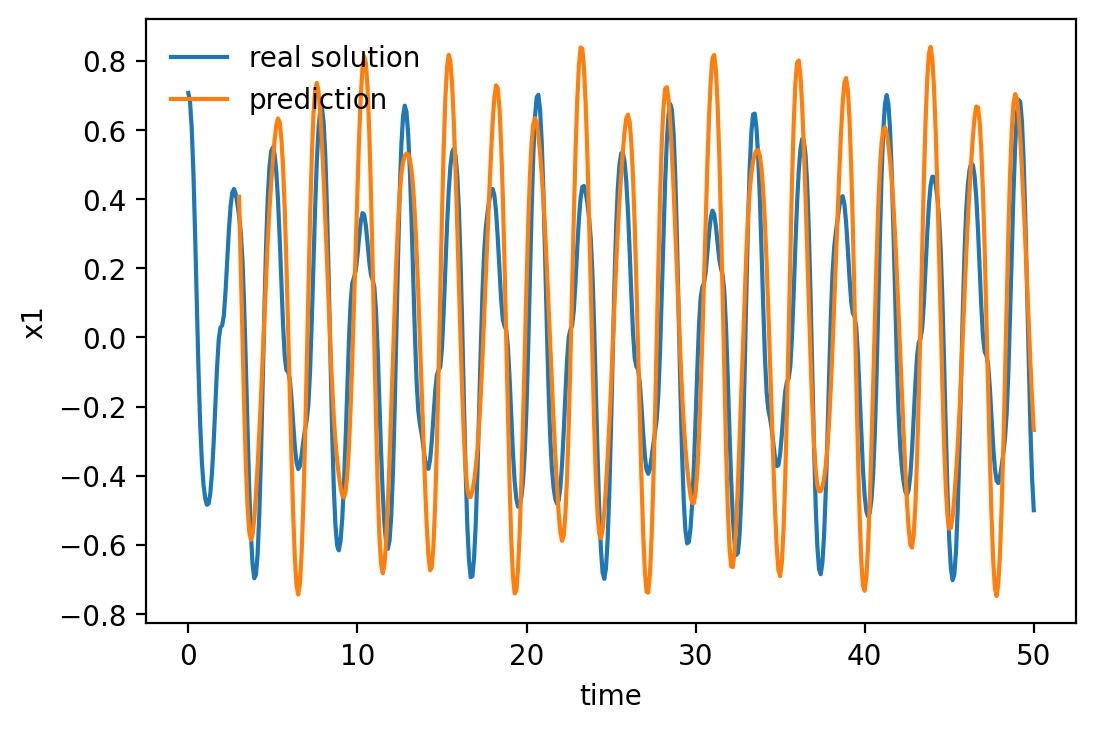

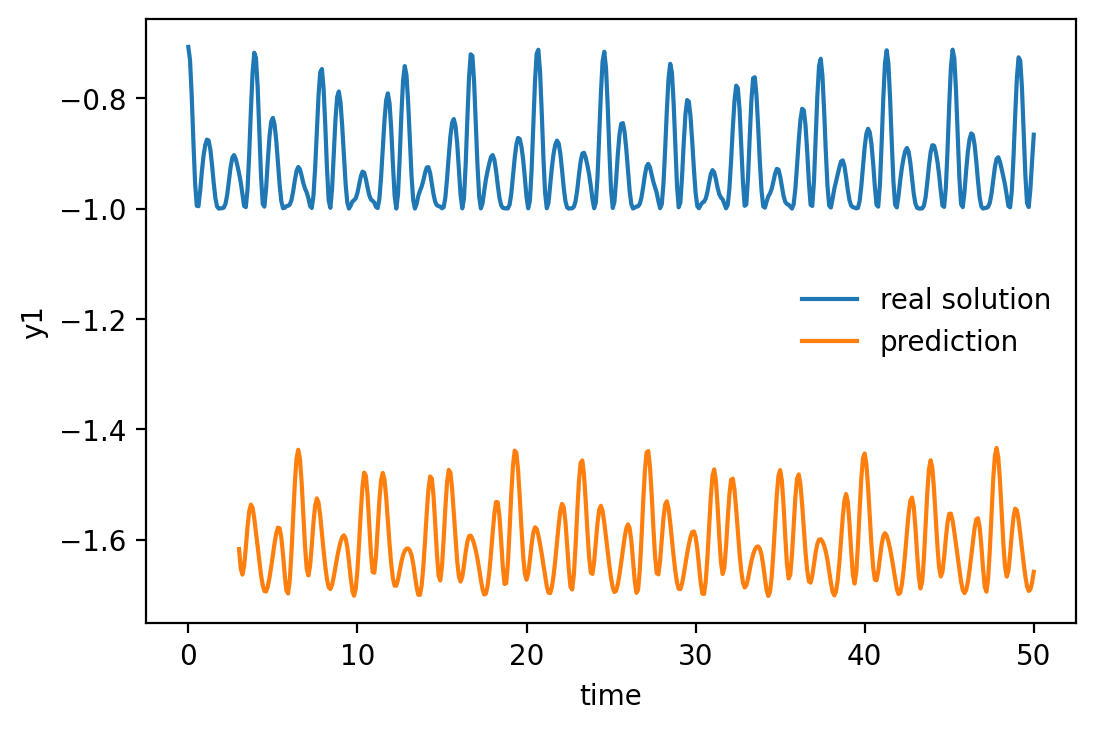

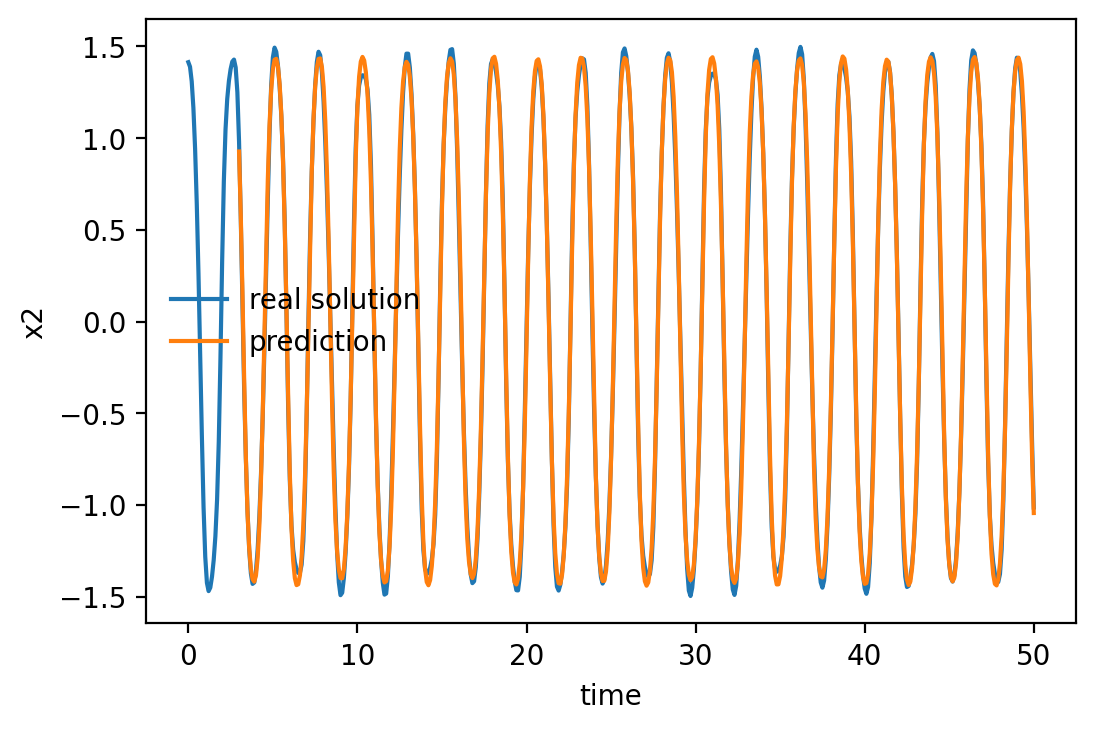

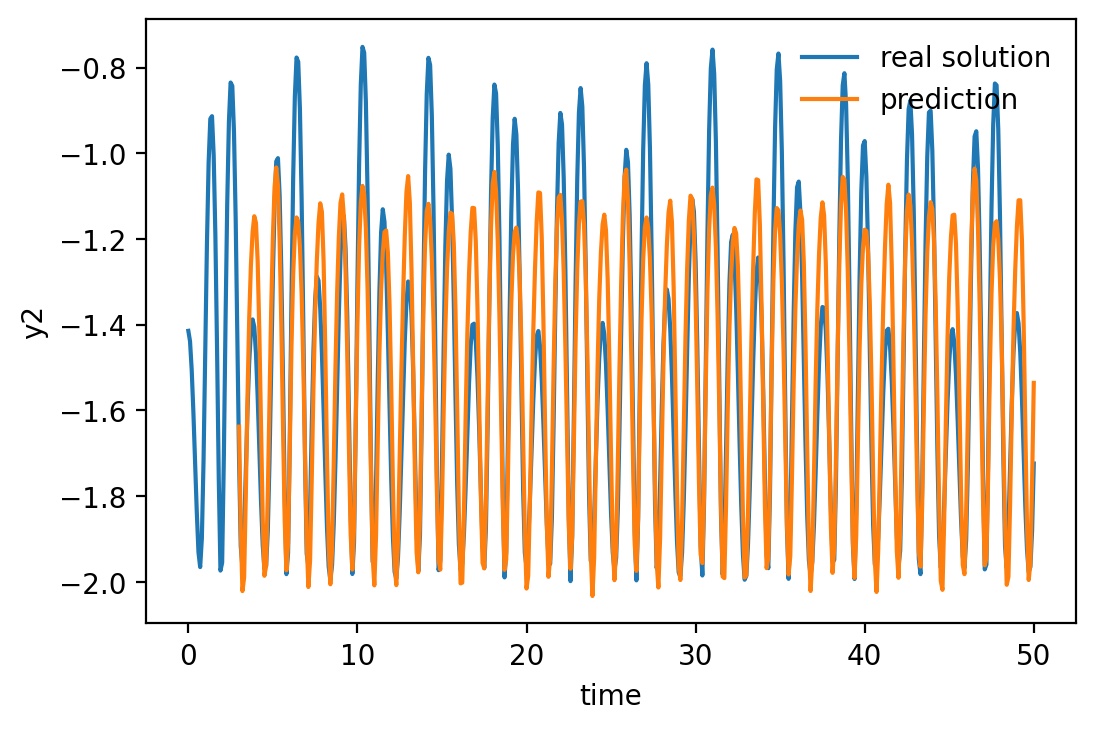

In [ ]:
def predict2(windowsize,offset,x1,y1,x2,y2):
  '''
  Uses a RNN with an LSTM layer of 64 neurons to predict future positions
  x1,y1,x2,y2 by only training on the positions of mass m2 (x2,y2).
  '''
  data = np.stack([x2, y2]).T
  # split data set into training and testing
  train_data = data[:400]
  test_data1 = np.stack([x1, y1]).T
  test_data2 = data

  # get input and target windows
  train_inputs, train_outputs = shapeArray(train_data, windowsize, offset)
  test_in1, test_out1 = shapeArray(test_data1, windowsize, offset)
  test_in2, test_out2 = shapeArray(test_data2, windowsize, offset)

  # define model with LSTM layer of 64 neurons
  model = model=keras.models.Sequential()
  model.add(keras.layers.LSTM(64,input_shape=(None,2),return_sequences=False))
  model.add(keras.layers.Dense(2,activation="linear"))
  model.compile(loss='mean_squared_error',optimizer='adam') # compile

  # train
  model.fit(train_inputs, train_outputs, batch_size = 100, epochs=100, verbose=0)

  # predict positions of m1
  preds1 = model.predict(test_in1)
  x1pred = preds1[:,0 ]
  y1pred = preds1[:,1 ]

  # predict positions of m2
  preds2 = model.predict(test_in2)
  x2pred = preds2[:,0 ]
  y2pred = preds2[:,1 ]

  return x1pred,y1pred,x2pred,y2pred

x1pred3,y1pred3,x2pred3,y2pred3 = predict2(10,20,x1,y1,x2,y2) # predict on initial conditions
predplot(x1,x1pred3,y1,y1pred3,x2,x2pred3,y2,y2pred3,10,20,2) # prediction vs real solution plots

Our model is definitely worse at predicting the positions of $m_1$ as shown by the graphs above, as expected. Unexpectedly, the $y$ position of $m_2$ is also subjected to a worse prediction in this case and the $x$ positions look like they have consistently better predictions than their $y$ counterparts which seems to be a recurring theme. This means the network consistently thinks our masses are reaching higher or lower positions than they truly are.

Time to calculate the deviations:

13/13 [==============================] - 0s 4ms/step


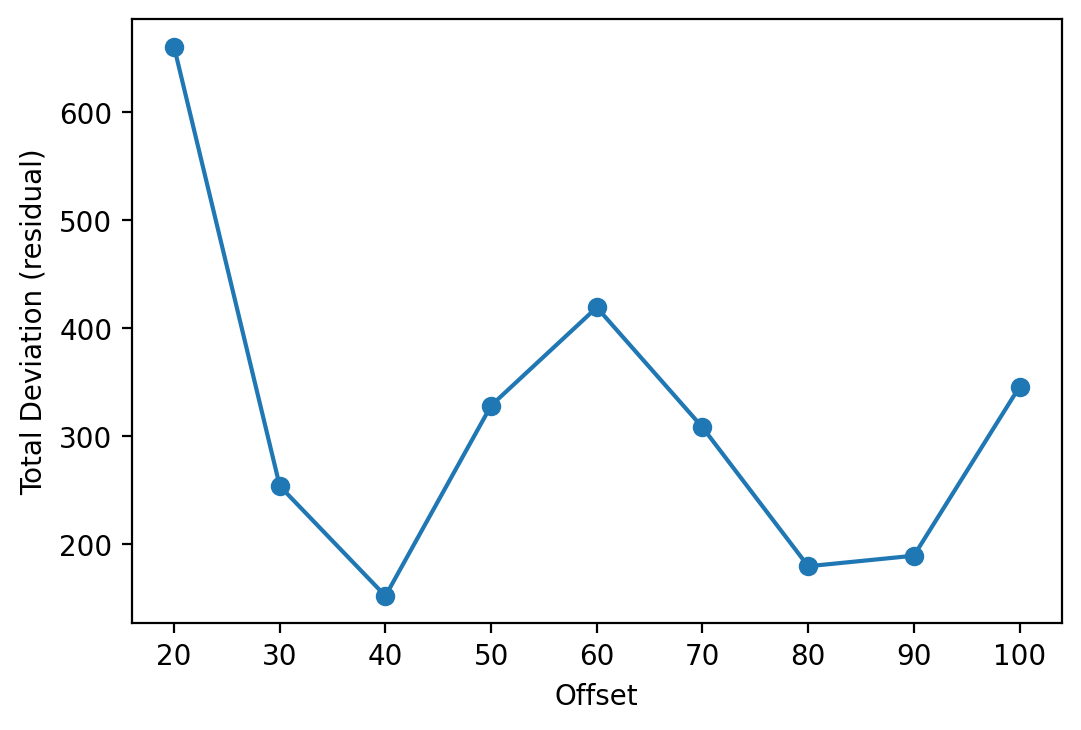

In [ ]:
deviations(x1,y1,x2,y2,10,task5=True) # total deviation plots

The deviations are of a much higher order than in Task 3, but display the same kind of trend. It may be viable to predict far into the future for our system of initial conditions.

Now to change the initial conditions and see what happens to our predictions:

13/13 [==============================] - 0s 3ms/step


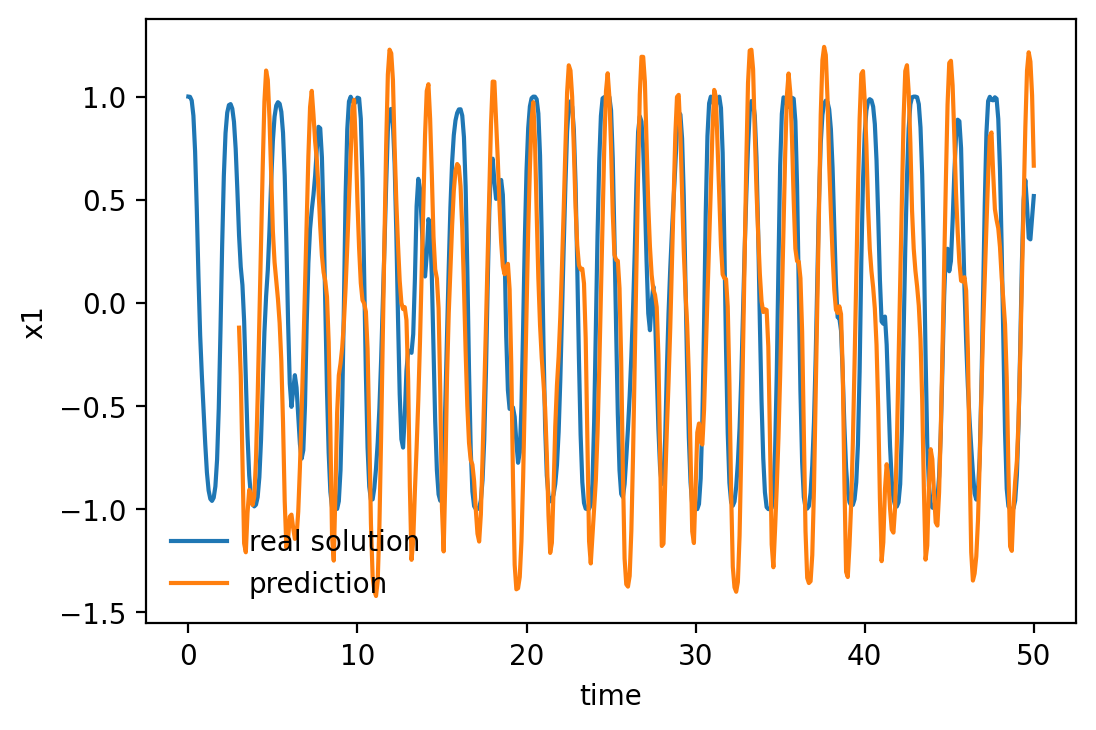

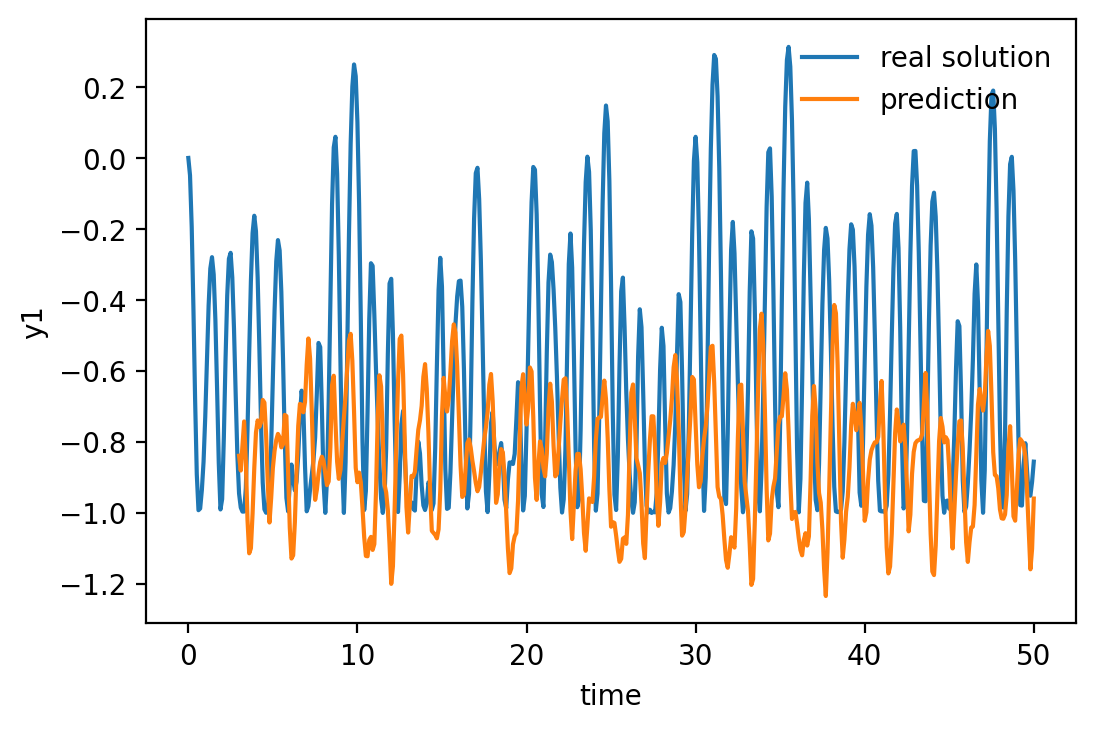

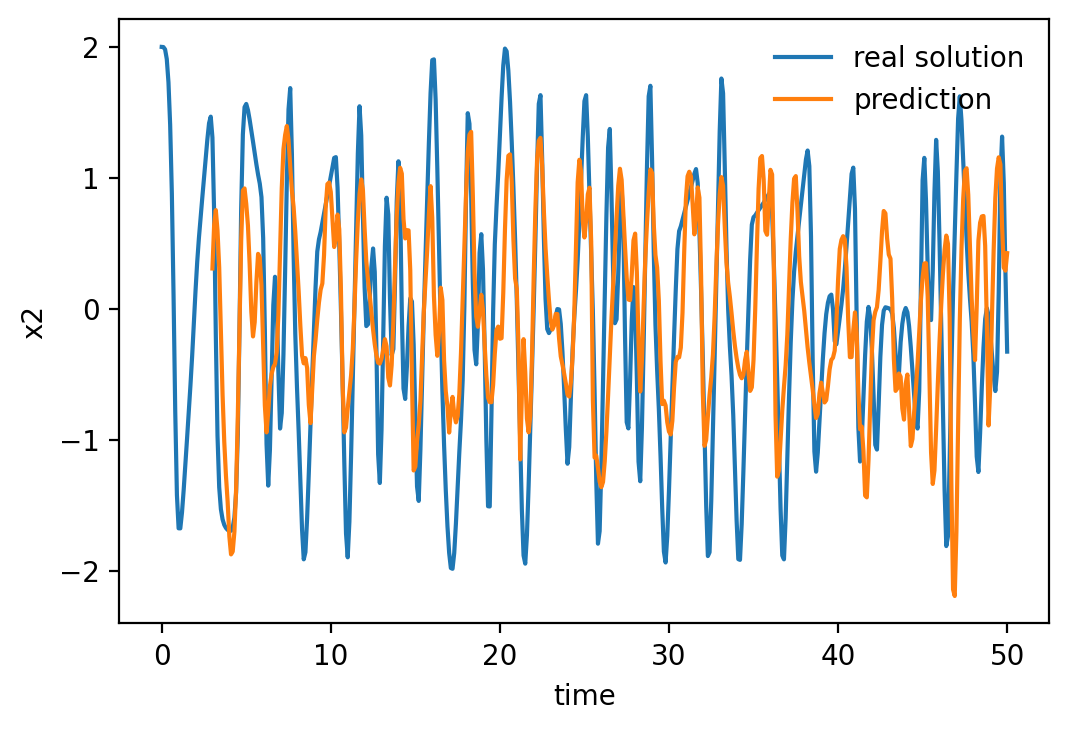

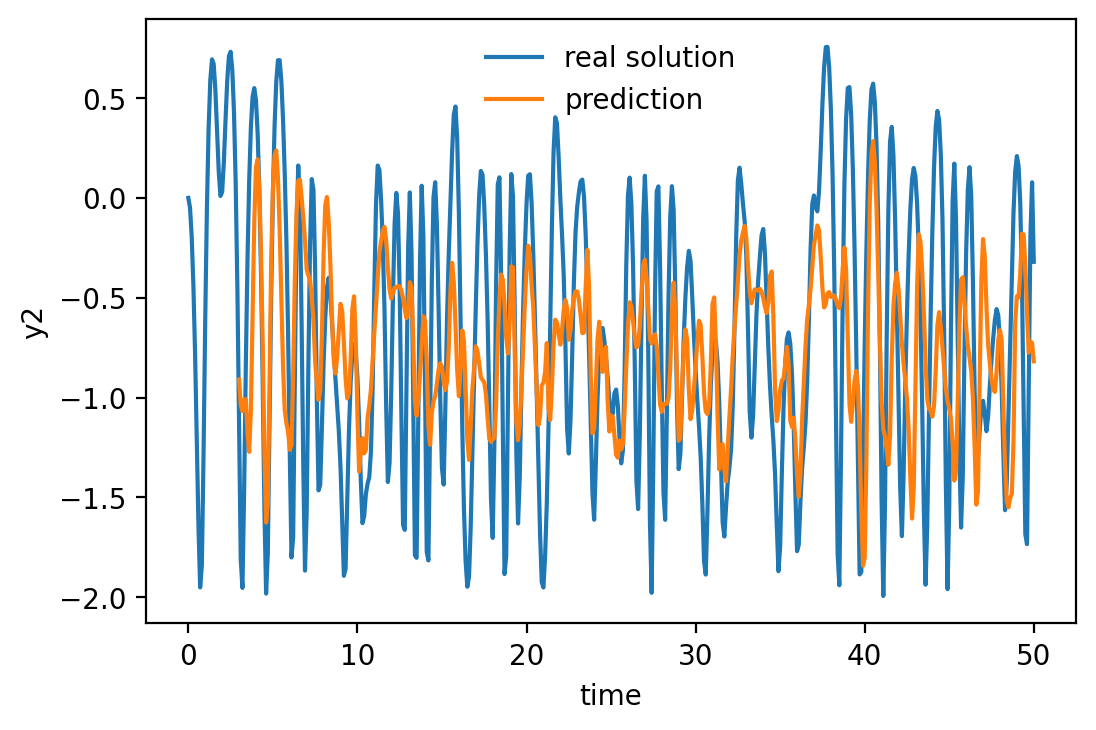

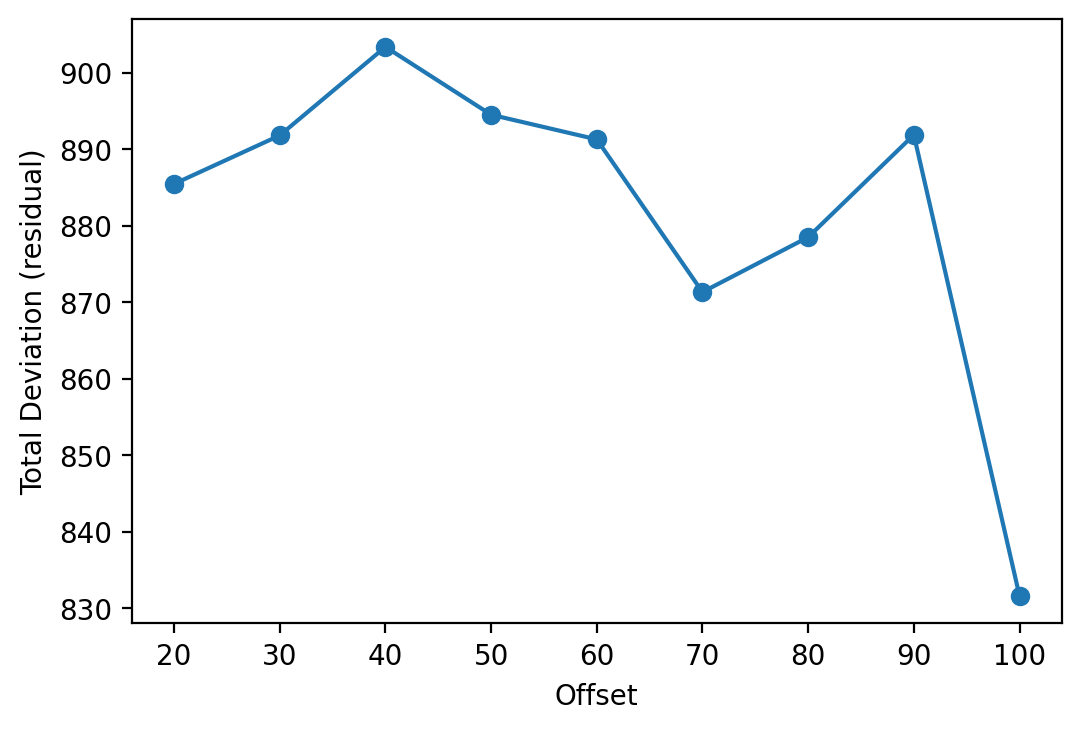

In [ ]:
task4(z1,rhs,tmax,t,L1,L2,m1,m2,g,task5=True) # change of initial conditions

Looks like only training on $m_2$ and trying to predict the positions of $m_1$ definitely has a worse performance than training on both. However, it is remarkable that the network is able to somewhat predict $m_1$ positions to some degree of accuracy (especially $x_1$!). As usual, the more chaotic system with the new conditions does lead to higher deviations than with the initial ones. However, in this case, the offset does not seem to have such a big impact on the deviation magnitude.